In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.plotting.register_matplotlib_converters()

import numpy as np
import seaborn as sns
import missingno as mgn

import plotly.express as px

Reading the data with standard preprocessing steps

In [ ]:
# Just the new file only - for now
df1 = pd.read_excel('../data/data_d-drivers_2024-03-24.xlsx', sheet_name='data',
                    )
df2 = pd.read_excel('../data/data_d-drivers_2024-03-26.xlsx', sheet_name='data')

df1.columns = [col.lower() for col in df1.columns]
df2.columns = [col.lower() for col in df2.columns]

df1.rename({
           'impressions': 'page_impressions',
           'page_efahrer_id': 'page_id',
           'published_at': 'publish_date',
           'page_canonical_url': 'url',
           'page_author': 'authors', 
            }, axis=1, inplace=True)

df2.rename({
           'impressions': 'page_impressions',
           'page_efahrer_id': 'page_id',
           'published_at': 'publish_date',
           'page_canonical_url': 'url',
           'page_author': 'authors', 
            }, axis=1, inplace=True)

What makes each entry unique?

In [ ]:
df1[df1[['page_id', 'date', 'url', 'authors', 'word_count']].duplicated(keep=False)] # keep=False keeps all duplicated values
                                    #.sort_values(['page_id', 'date', 'url', 'page_author'])

By experimenting with different sets of columns I found those are 

> 'page_id', 'date', 'url', 'authors', 'word_count'

* NOT the `page_name`: it is totally broken
* NOT the `publish_date`: sometimes the articles changed several times during the day and the word count changed, so `publish_date` does not capture all combinations

Addressing the rows by all of those columns makes every article unique but just a single one: 1018299 (rows 66544 and 78658). But the second entry is just a mistake with all missing values, it can be simply dropped. 

In [ ]:
df1.drop(78658, inplace=True)

Merge on those:

In [ ]:
key_columns = ['page_id', 'date', 'url', 'authors', 'word_count']

What columns are in `df1` and not in `df2`?

In [ ]:
print(df2.columns.difference(df1.columns))
print(df1.columns.difference(df2.columns))

So the page impressions only present in the 2nd delivery, and clickouts only in the first delivery. 
We will merge the *first to the second*, so in the first dataset we only want to have the key columns and the unique one.

In [ ]:
df1 = df1[key_columns + ['clickouts']]

What pages are in df1 and not in df2 and the other way around?

In [ ]:
print(df1.set_index('page_id').index.difference(df2.set_index('page_id').index))
print(df2.set_index('page_id').index.difference(df1.set_index('page_id').index))

> The new data delivery includes all pages from the first one + 8 new ones.

What `URLs` are in df1 and not in df2 and the other way around?

In [ ]:
print(df1.set_index('url').index.difference(df2.set_index('url').index))
print(df2.set_index('url').index.difference(df1.set_index('url').index))

> 22 new URLs

Which dates are new?

In [ ]:
print(df1.set_index('date').index.difference(df2.set_index('date').index))
print(df2.set_index('date').index.difference(df1.set_index('date').index))

> The day between the first and the second data deliveries, makes a lot of sense :D

In [ ]:
if df1.shape == df1.drop_duplicates().shape:
    print('No duplicates left in the first dataframe')
else: 
    print('Duplicated entries present: merging will blow up the data frame size')

In [ ]:
if df2[key_columns].shape == df2[key_columns].drop_duplicates().shape:
    print('No duplicates are in the second dataframe')
else: 
    print('Duplicated entries present: merging will blow up the data frame size')

In [ ]:
df2[df2[key_columns].duplicated(keep=False)] # keep=False keeps all duplicated values
                                    #.sort_values(['page_id', 'date', 'url', 'page_author'])

Same mistake is in `df2`: remove it.

In [ ]:
df2.drop(40600, inplace=True)

In [ ]:
if df2[key_columns].shape == df2[key_columns].drop_duplicates().shape:
    print('No duplicates are in the second dataframe')
else: 
    print('Duplicated entries present: merging will blow up the data frame size')

In [ ]:
# Because a the data for df1 is imported from a csv and for df2 from an excel sheet, the data types differ. 
# To avoid conflicts when merging, let's change the column type from object to date for the date column in df1.
df1["date"] = pd.to_datetime(df1["date"])
print(df1.dtypes)
print(df2.dtypes)

page_id                int64
date          datetime64[ns]
url                   object
authors               object
word_count           float64
clickouts            float64
dtype: object
page_id                                int64
date                          datetime64[ns]
publishing_date               datetime64[ns]
publish_date_equal_to_date            object
url                                   object
page_name                             object
classification_product                object
classification_type                   object
title                                 object
authors                               object
daily_likes                          float64
daily_dislikes                       float64
word_count                           float64
video_play                           float64
page_impressions                     float64
external_clicks                      float64
external_impressions                 float64
dtype: object


Yuppi, now we are ready to merge!

## Merging

Using the `left` merging: we already know that `df1` is malformatted

In [ ]:
df = pd.merge(left=df2, right=df1, on=key_columns, how='left') 
# in principle, even the page_id is redundant in this case, 
# because each url contains the page id as the suffix

df

In [ ]:
df2.shape

In [ ]:
mgn.matrix(df);

Cleaning up

In [ ]:
del df1
del df2

## Imputing

In [ ]:
df = df.sort_values(['page_id', 'date', 'publish_date', 'url']).reset_index(drop=True)

In [ ]:
article10437 = df[df.page_id == 10437]
article10437.shape

In [ ]:
article10437.loc[article10437.date < article10437.publish_date, 'publish_date']# = pd.Timestamp('2018-01-01 00:00:00')

In [ ]:
versions2_10437 = article10437.groupby(['page_id'], as_index=False, sort=True)[
    ['page_id', 'date', 'publish_date', 'word_count']
    ].ffill().drop_duplicates(['page_id', 'date', 'publish_date'])
versions2_10437

In [ ]:
temp = pd.merge(article10437.drop(['publish_date', 'word_count'], axis=1).drop_duplicates(['page_id', 'date', 'url', 'authors']), 
                versions2_10437,
         on=['page_id', 'date'], how='inner')
temp

#### Article versions

In [ ]:
df[(df['publish_date_equal_to_date'] == 'Y') & (df['publish_date'].isna())]

Attention: some articles were scheduled for an update (or first publication), therefore have already existing entries and stats (likes, dislikes, etc.)

In [ ]:
scheduled_articles = df.query('date < publish_date')#[df.columns.drop(['url', 'title', 'page_name'])]

In [ ]:
scheduled_articles_ids = scheduled_articles.page_id.unique()

In [ ]:
df.columns

In [ ]:
# Grouping, so we are not filling in the values from other articles!
versions = df.groupby(['page_id'], as_index=False, sort=True)[
    ['page_id', 'date', 'publish_date', 'word_count']
    ].ffill()
#versions.rename({'index': 'page_id'}, axis=1, inplace=True)
versions

In [ ]:
versions.query('date < publish_date').shape[0] == scheduled_articles.shape[0]

In [ ]:
wtf_idx = versions.query('date < publish_date').index.difference(scheduled_articles.index)
wtf_idx

<font color=red> We'll assume that all articles which don't have a publishing date but were scheduled for an update are actually REALLY OLD and were published at the around inception of EFAHRER (01-01-2018) </font>

In [ ]:
df.loc[df.date < df.publish_date, 'publish_date'] = pd.Timestamp('2018-01-01 00:00:00')

For some pages we simply don't know the date of first publication! We need to impute it for modelling.
Which articles are those?

In [ ]:
no_publ_date = versions[versions.publish_date.isna()].page_id.unique()
no_publ_date

In [ ]:
no_publ_date.shape 

In [ ]:
len(no_publ_date) / len(df.page_id.unique())

So those entries comprise almost 34 % of all articles :(

**For those we apply the same imputing**

In [ ]:
df.loc[df.page_id.isin(no_publ_date), 'publish_date'] = pd.Timestamp('2018-01-01 00:00:00')

<font color=red> Assuming that when the word counts do not change unless ptherwise specified </font>

In [ ]:
versions2 = df.groupby(['page_id'], as_index=False, sort=True)[
    ['page_id', 'date', 'publish_date', 'word_count']
    ].ffill().drop_duplicates()

versions2

In [ ]:
versions[(versions.date < versions.publish_date)]

Merging the imputed columns back in:

In [ ]:
versions2.columns

In [ ]:
df.columns.drop('publish_date').drop('word_count')

In [ ]:
df_imputed = pd.merge(df[df.columns.drop('publish_date').drop('word_count')], # drop the non-imputed columns
                      versions2,
                      on=['page_id', 'date'], how='left')

In [ ]:
mgn.matrix(df_imputed)

#### Daily reactions

In [ ]:
df['daily_likes']

0         0.0
1         0.0
2         0.0
3         0.0
4         1.0
         ... 
132840    NaN
132841    NaN
132842    NaN
132843    NaN
132844    NaN
Name: daily_likes, Length: 132845, dtype: float64

### Merging in the scraped data

Thanks Clara

In [ ]:
df_scraped = pd.read_csv('../data/scraping_no_duplicates.csv')
df_scraped.columns = [col.lower() for col in df_scraped.columns]

df_scraped.rename({
           #'impressions': 'page_impressions',
           'words': 'words_scraped',
           'page_efahrer_id': 'page_id',
           'page_canonical_url': 'url',
           'author': 'author_scraped',
           'current_title': 'h1'
            }, axis=1, inplace=True)

col_to_merge = ['page_id', 'url']
df_full = pd.merge(left=df, right=df_scraped, on=col_to_merge, how='left')

In [ ]:
df_full = df_full.drop('publish_date_equal_to_date', axis=1)

In [ ]:
mgn.matrix(df_full);

In [ ]:
df_full = df_full.sort_values(['page_id', 'date', 'publish_date'])

### Imputing (again)

<font color=red> Imputing with forward-fill </font>
<font color=red> Impute word counts with 0 </font> 

-> In the future: take the value of the `word count (scraped)` or the mean value for the given category! 

In [ ]:
df_full['word_count'] = df_full.groupby(['page_id', 'date'])['word_count'].ffill()
df_full['word_count'] = df_full['word_count'].fillna(0)

df_full['publish_date'] = df_full.groupby(['page_id', 'date'])['publish_date'].ffill()
df_full['publish_date'] = df_full.groupby(['page_id'])['publish_date'].ffill()

---

# Aggregating 

For using in subprojects

In [ ]:
page_unique_features = ['page_id', 'publish_date', 'word_count', 'authors']

In [ ]:
df_full.columns

In [ ]:
(df_full[page_unique_features + ['date']].drop_duplicates().value_counts() > 1).sum()

this means they are really unique

#### Versions

In [ ]:
#df_versions['version_n'] = 
temp = df_full[['page_id', 'word_count', 'publish_date', 'authors']].drop_duplicates()
temp = temp.fillna({'word_count': 0, 'publish_date': pd.Timestamp('2018-01-01 00:00')})
temp = temp.drop_duplicates()
temp = temp.sort_values('publish_date')

In [ ]:
wc_versions = temp.groupby('page_id')['word_count'].transform(lambda x: pd.factorize(x)[0])
publish_versions = temp.groupby('page_id')['publish_date'].transform(lambda x: pd.factorize(x)[0])
authors_versions = temp.groupby('page_id')['authors'].transform(lambda x: pd.factorize(x)[0])

In [ ]:
version_count = 1000*wc_versions + 100*publish_versions + 1*authors_versions
temp['ver_id_wc'] = wc_versions
temp['ver_id_pub'] = publish_versions
temp['ver_id_auth'] = authors_versions
temp['version_id_raw'] = version_count
#version_count = pd.factorize(version_count)[0]

In [ ]:
temp['version_id'] = temp.groupby('page_id')['version_id_raw'].transform(lambda x: pd.factorize(x)[0])

In [ ]:
df_full_versions = pd.merge(df_full, temp.drop(['ver_id_wc', 'ver_id_pub', 'ver_id_auth', 'version_id_raw'], axis=1),
         on=['page_id', 'word_count', 'publish_date', 'authors'],
         how='left')

In [ ]:
# df_full_versions['word_count'] = df_full_versions.groupby('page_id')['word_count'].fillna(0)

### User-side

User side features: those which the reader sees

In [ ]:
user_side_features = ['page_id', 'date', 'publish_date', 'word_count', 'words_scraped', 
                    'page_title', 'page_name', 'title', 'h1', 'authors',  
                    'classification_product', 'classification_type']

---

## Feature engineering

### Article (content) versions

We want to label each version.
* Version changes when there is a new `publication date`
* Version changes when there is a new `word count`
* Version does NOT change with a change in `URL`
* Version does NOT change with a change in the `date` column

In [ ]:
# Only the necessary columns
# we still need the 'date' column for imputation
df_cnt = df[['page_id', 'date', 'publishing_date', 'word_count']]
df_cnt = df_cnt.sort_values(['page_id', 'date', 'publishing_date'])
df_cnt

,page_id,date,publishing_date,word_count
0,1037,2024-03-13,2024-03-10,827.0
1,1037,2024-03-13,2024-03-10,827.0
2,1037,2024-03-14,2024-03-10,827.0
3,1037,2024-03-15,2024-03-10,827.0
4,1037,2024-03-16,2024-03-10,827.0
...,...,...,...,...
132840,1018768,2024-03-23,NaT,NaN
132841,1018770,2024-03-23,NaT,NaN
132842,1018771,2024-03-23,NaT,NaN
132843,1018776,2024-03-23,NaT,NaN


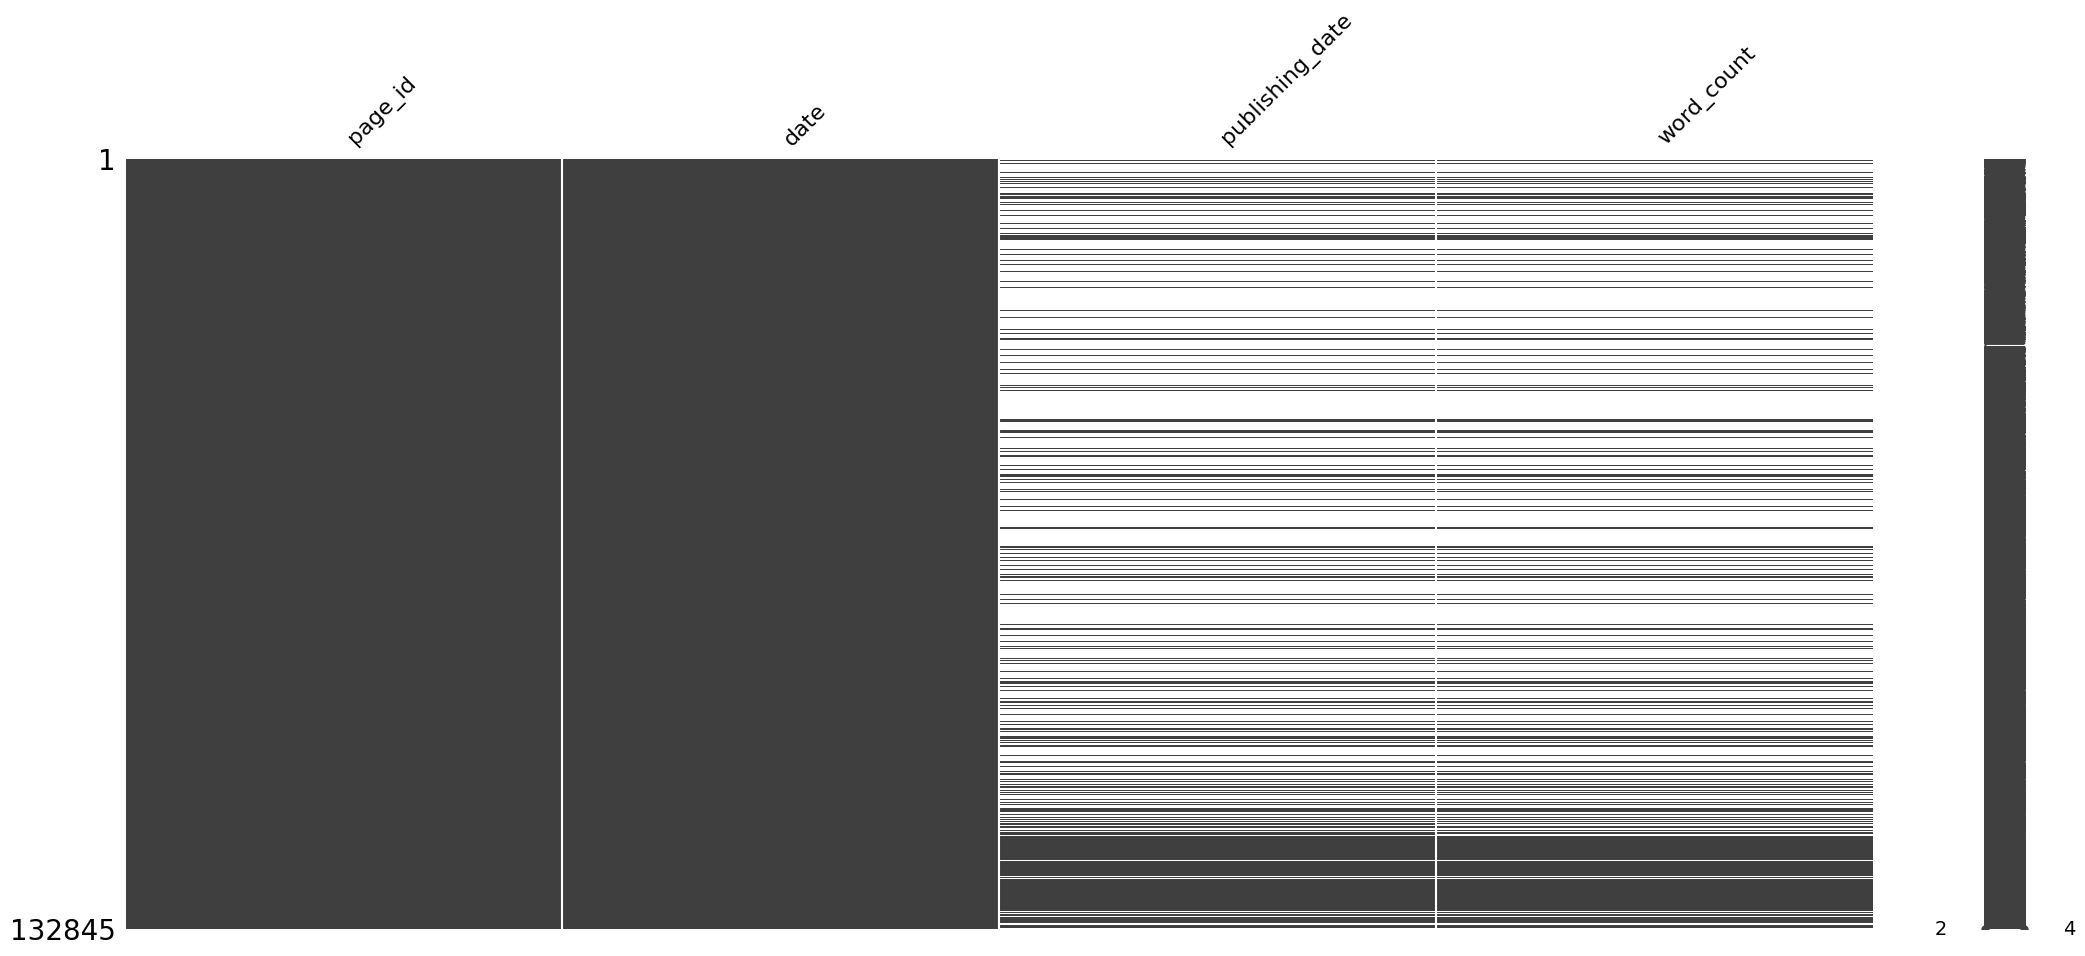

In [ ]:
mgn.matrix(df_cnt);

There are some columns where the publication date changed but the `word count` was not updated!

In [ ]:
wcna_idx = df_cnt[df_cnt.word_count.isna() & df_cnt.publishing_date.notna()].index
wcna_idx

Index([ 15641,  27554,  27556,  27557,  27558,  27559,  27560,  27561,  27562,
        44631,
       ...
       132341, 132342, 132343, 132344, 132345, 132346, 132347, 132704, 132705,
       132757],
      dtype='int64', length=472)

NOT the other way around:

In [ ]:
df_cnt[df_cnt.word_count.notna() & df_cnt.publishing_date.isna()].index

Index([], dtype='int64')

The best assumption that it did not change (significantly??), so still forward-fill it.

In [ ]:
df_cnt = df_cnt.ffill()

In [ ]:
sus = df_cnt.loc[wcna_idx]

#### Versions

In [ ]:
df_cnt['publ_at_enc'] = df_cnt.groupby('page_id')['publishing_date'].transform(lambda x: pd.factorize(x)[0])
df_cnt

,page_id,date,publishing_date,word_count,publ_at_enc
0,1037,2024-03-13,2024-03-10,827.0,0
1,1037,2024-03-13,2024-03-10,827.0,0
2,1037,2024-03-14,2024-03-10,827.0,0
3,1037,2024-03-15,2024-03-10,827.0,0
4,1037,2024-03-16,2024-03-10,827.0,0
...,...,...,...,...,...
132840,1018768,2024-03-23,2024-03-21,349.0,0
132841,1018770,2024-03-23,2024-03-21,349.0,0
132842,1018771,2024-03-23,2024-03-21,349.0,0
132843,1018776,2024-03-23,2024-03-21,349.0,0


How many versions does each article have?

In [ ]:
to_plot = df_cnt[['page_id', 'publ_at_enc']].groupby('page_id').max()#.reset_index()
first_publ_date = df_cnt[['page_id', 'publishing_date']].groupby('page_id').min()
first_publ_date = first_publ_date.rename({'publishing_date': 'First publication date'}, axis=1)
to_plot = to_plot.join(first_publ_date)
to_plot = to_plot.rename({'publ_at_enc': 'Number of versions'}, axis=1)
to_plot

,Number of versions,First publication date
page_id,,
1037,0,2024-03-10
1039,0,2022-05-05
1040,0,2024-02-21
10245,0,2024-02-21
10273,4,2023-11-29
...,...,...
1018768,0,2024-03-21
1018770,0,2024-03-21
1018771,0,2024-03-21


In [ ]:
px.scatter(data_frame=to_plot, x='Number of versions', y='First publication date')

Article with 61 (!!!) versions: 105259

In [ ]:
metrics_cols = ['url', 'daily_likes', 
               'daily_dislikes', 'page_impressions', 'video_play', 
               'external_clicks', 'external_impressions']

In [ ]:
article105259 = df[df['page_id']==105259].sort_values(['date', 'url'])
article_first_url = article105259[metrics_cols + ['date']].drop_duplicates(subset=['date'], keep='first')

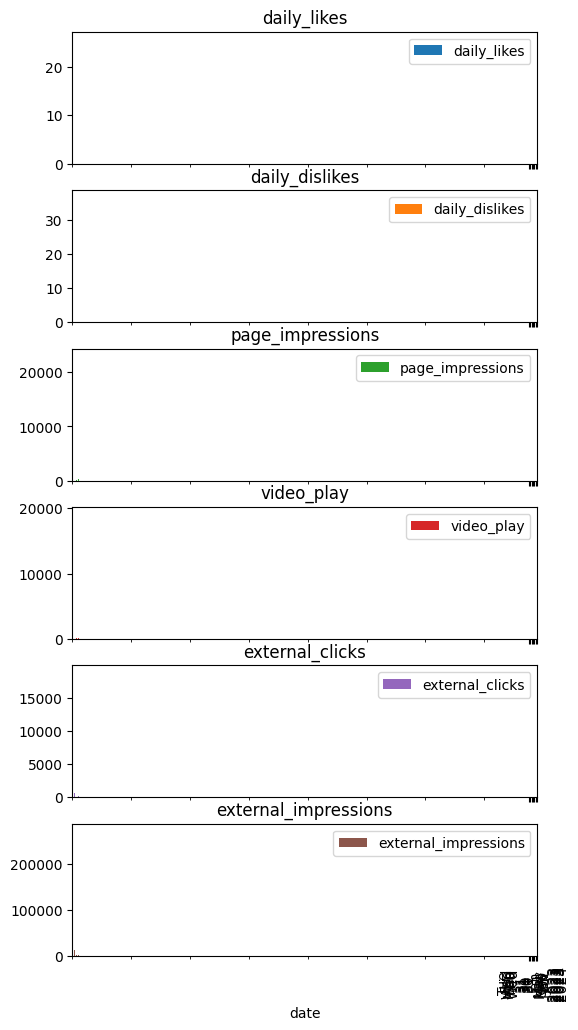

In [ ]:
import matplotlib.pyplot as plt

xticks=pd.date_range(df.date.min(), df.date.max(), freq='2M')
fig = article_first_url.plot(kind='bar', x='date', y=metrics_cols, subplots=True, figsize=(6, 12), 
                       xticks=xticks)
plt.gca().set_xticklabels([x.strftime('%a\n%d\n%h\n%Y') for x in xticks]);
# plt.xticks(ticks=df[['page_impressions', 'publishing_date']].resample('W', on='publishing_date').max().index);
# plt.xticks(ticks=pd.date_range(df.date.min(), df.date.max(), freq='2M'),
#            labels=pd.date_range(df.date.min(), df.date.max(), freq='2M'));

----

# Cleaning 2

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 30)

df_full = pd.read_csv('../data/full_data.csv')
df_full

Drop the columns with negative likes, dislikes and too many reactions

In [ ]:
df_full.query('daily_likes < 10000').shape

In [ ]:
art1013096 = df_full.query('page_id == 1013096')